In [1]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classification

In [18]:
def calculate_loss(X, y, model):
    pred = model(X)
    return F.binary_cross_entropy(pred, y.unsqueeze(1)) 

def train(model, train_loader, val_loader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    train_losses = []
    val_losses = []
    model.to(device)
    for i in tqdm(range(epochs)):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Validation
        loss_mean = 0 
        elements = 0
        for X, y in iter(val_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        val_losses.append(loss_mean / elements)
        #print("Epoch", i, "| Train loss", train_losses[-1], "| Validation loss", val_losses[-1])
    return train_losses, val_losses

def plot_losses(train_l, val_l):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_l)), train_l, label="train")
    plt.plot(range(len(val_l)), val_l, label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
labels_train = torch.Tensor(np.load(embedding_path + 'labels.npy'))
labels_val = torch.Tensor(np.load(embedding_path + 'labels_val.npy'))

In [19]:
def get_classifier(model_name, n_hidden=256, n_input=2048):
    classifier = nn.Sequential(
                nn.Linear(n_input, n_hidden),
                nn.BatchNorm1d(num_features=n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, 1),
                nn.Sigmoid())

    path_train = embedding_path + model_name + '.npy'
    path_val = embedding_path + model_name + '_val.npy'

    emb_train = torch.Tensor(np.load(path_train).astype(np.float32))
    emb_val = torch.Tensor(np.load(path_val).astype(np.float32))

    dataset_train = TensorDataset(emb_train, labels_train)
    dataset_val = TensorDataset(emb_val, labels_val)

    train_loader = DataLoader(dataset_train, batch_size=128)
    val_loader = DataLoader(dataset_val, batch_size=128)
    return classifier, train_loader, val_loader

#### BYOL with not pretrained resnet50




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<02:17,  3.64it/s]

  0%|          | 2/500 [00:00<02:17,  3.63it/s]

  1%|          | 3/500 [00:00<02:17,  3.63it/s]

  1%|          | 4/500 [00:01<02:17,  3.60it/s]

  1%|          | 5/500 [00:01<02:16,  3.62it/s]

  1%|          | 6/500 [00:01<02:17,  3.59it/s]

  1%|▏         | 7/500 [00:01<02:18,  3.57it/s]

  2%|▏         | 8/500 [00:02<02:17,  3.58it/s]

  2%|▏         | 9/500 [00:02<02:16,  3.61it/s]

  2%|▏         | 10/500 [00:02<02:16,  3.58it/s]

  2%|▏         | 11/500 [00:03<02:17,  3.56it/s]

  2%|▏         | 12/500 [00:03<02:16,  3.57it/s]

  3%|▎         | 13/500 [00:03<02:16,  3.56it/s]

  3%|▎         | 14/500 [00:03<02:16,  3.55it/s]

  3%|▎         | 15/500 [00:04<02:15,  3.58it/s]

  3%|▎         | 16/500 [00:04<02:13,  3.64it/s]

  3%|▎         | 17/500 [00:04<02:13,  3.61it/s]

  4%|▎         | 18/500 [00:05<02:14,  3.60it/s]

  4%|▍         | 19/500 [00:05<02:13,  3.60it/s]

  4%|▍         |

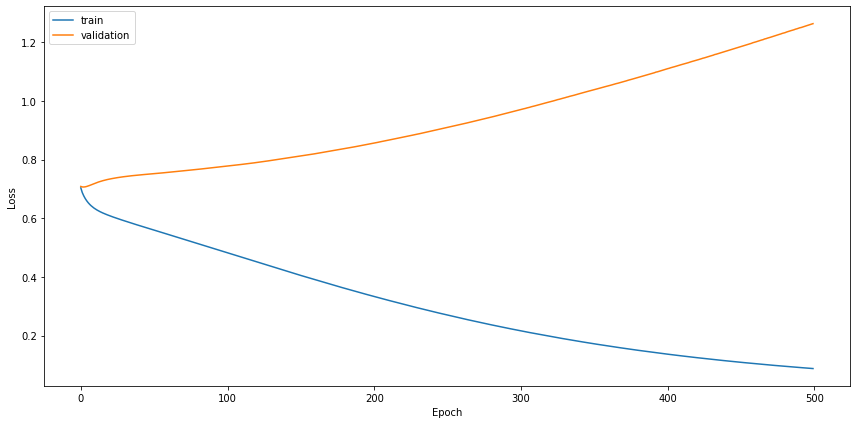

In [20]:
classifier, train_loader, val_loader = get_classifier(model_name='resnet50_not_pretrained_epoch=830')
train_l, val_l = train(classifier, train_loader, val_loader, 500)
plot_losses(train_l, val_l)

In [21]:
y_pred_ = []

true_positive = np.zeros(2)
true_negative = np.zeros(2)
false_positive = np.zeros(2)
false_negative = np.zeros(2)
accuracy = 0
ctn = 0
for X, y in iter(val_loader):
    X = X.to(device)
    y = y.to(device)
    y = y.type(torch.uint8)
    with torch.no_grad():
        y_prob = classifier(X)
    y_pred = (y_prob > 0.5).type(torch.uint8) 
    for i in range(2):
      for pred, real in zip(y_pred, y):
        if real == i:
          if pred == real:
            true_positive[i] += 1
          else:
            false_negative[i] += 1
        else:
          if pred == i:
            false_positive[i] += 1
          else:
            true_negative[i] += 1

    y_pred_.extend(y_pred.detach().cpu().numpy())
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
  
# print(true_positive)
# print(true_negative)
# print(false_positive)
# print(false_negative)

print("Overall accuracy:", accuracy / ctn)
y = np.load(embedding_path + 'labels_val.npy')
print('AUCROC:', roc_auc_score(y, y_pred_))
# print("Precision", true_positive / (true_positive + false_positive))
# print("Recall", true_positive / (true_positive + false_negative))
# print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
# print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy: 63.956
AUCROC: 0.534


## resnet50



  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<02:12,  3.76it/s]

  0%|          | 2/500 [00:00<02:18,  3.60it/s]

  1%|          | 3/500 [00:00<02:15,  3.66it/s]

  1%|          | 4/500 [00:01<02:14,  3.68it/s]

  1%|          | 5/500 [00:01<02:16,  3.63it/s]

  1%|          | 6/500 [00:01<02:15,  3.64it/s]

  1%|▏         | 7/500 [00:01<02:13,  3.69it/s]

  2%|▏         | 8/500 [00:02<02:13,  3.68it/s]

  2%|▏         | 9/500 [00:02<02:14,  3.64it/s]

  2%|▏         | 10/500 [00:02<02:15,  3.62it/s]

  2%|▏         | 11/500 [00:03<02:15,  3.62it/s]

  2%|▏         | 12/500 [00:03<02:13,  3.64it/s]

  3%|▎         | 13/500 [00:03<02:16,  3.56it/s]

  3%|▎         | 14/500 [00:03<02:15,  3.58it/s]

  3%|▎         | 15/500 [00:04<02:14,  3.61it/s]

  3%|▎         | 16/500 [00:04<02:13,  3.62it/s]

  3%|▎         | 17/500 [00:04<02:14,  3.60it/s]

  4%|▎         | 18/500 [00:04<02:12,  3.63it/s]

  4%|▍         | 19/500 [00:05<02:11,  3.66it/s]

  4%|▍         |

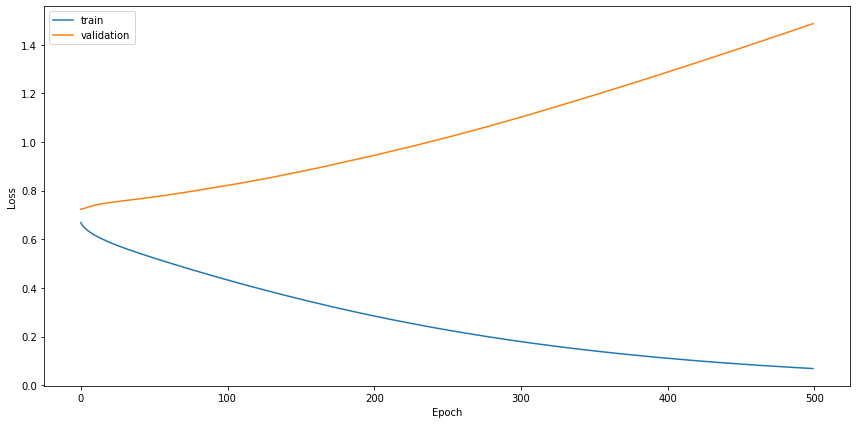

In [22]:
classifier, train_loader, val_loader = get_classifier(model_name='resnet50')
train_l, val_l = train(classifier, train_loader, val_loader, 500)
plot_losses(train_l, val_l)

In [23]:
y_pred_ = []

true_positive = np.zeros(2)
true_negative = np.zeros(2)
false_positive = np.zeros(2)
false_negative = np.zeros(2)
accuracy = 0
ctn = 0
for X, y in iter(val_loader):
    X = X.to(device)
    y = y.to(device)
    y = y.type(torch.uint8)
    with torch.no_grad():
        y_prob = classifier(X)
    y_pred = (y_prob < 0.5).type(torch.uint8) 
    for i in range(2):
      for pred, real in zip(y_pred, y):
        if real == i:
          if pred == real:
            true_positive[i] += 1
          else:
            false_negative[i] += 1
        else:
          if pred == i:
            false_positive[i] += 1
          else:
            true_negative[i] += 1

    y_pred_.extend(y_pred.detach().cpu().numpy())
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
  
# print(true_positive)
# print(true_negative)
# print(false_positive)
# print(false_negative)

print("Overall accuracy:", accuracy / ctn)
y = np.load(embedding_path + 'labels_val.npy')
print('AUCROC:', roc_auc_score(y, y_pred_))
# print("Precision", true_positive / (true_positive + false_positive))
# print("Recall", true_positive / (true_positive + false_negative))
# print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
# print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy: 63.132
AUCROC: 0.52
